In [1]:
# Import the libraries required.
import pickle
import tensorflow as tf
import numpy as np
from keras.models import Sequential
from keras.layers import Input, Flatten, Dense, Lambda, BatchNormalization, Convolution2D, Dropout, Cropping2D
from keras.models import Model
import json
import time
import cv2
import random


Using TensorFlow backend.


In [2]:
# create a generator to load data
import os
import csv
"""
filePath = []
file_round_threeloop = 'C:\\Users\\Elvin\\Desktop\\self-driving car\\CarND-Behavioral-Cloning-P3-master\\training_data\\roadfirst\\driving_log.csv'
file_round_CountClockwise = 'C:\\Users\\Elvin\\Desktop\\self-driving car\\CarND-Behavioral-Cloning-P3-master\\training_data\\roundCounter-Clockwise\\driving_log.csv'
file_roundCorner = 'C:\\Users\\Elvin\\Desktop\\self-driving car\\CarND-Behavioral-Cloning-P3-master\\training_data\\roundCorner\\driving_log.csv'
file_roundRecovery = 'C:\\Users\\Elvin\\Desktop\\self-driving car\\CarND-Behavioral-Cloning-P3-master\\training_data\\roundRecovery\\driving_log.csv'
file_classdata = 'C:\\Users\\Elvin\\Desktop\\self-driving car\\CarND-Behavioral-Cloning-P3-master\\class_data\\driving_log.csv'
#filePath = [file_round_threeloop, file_round_CountClockwise, file_roundCorner, file_roundRecovery]
file_Udacitydata = 'C:\\Users\\Elvin\\Desktop\\self-driving car\\CarND-Behavioral-Cloning-P3-master\\data\\Udacity_data\\driving_log.csv'
file_dirtroaddata = 'C:\\Users\\Elvin\\Desktop\\self-driving car\\CarND-Behavioral-Cloning-P3-master\\data\\Dirtroad_data\\driving_log.csv'
fillPath = [file_Udacitydata, file_dirtroaddata]
"""
samples = []

"""
# Using Multiple Cameras
for filename in filePath:
    with open(filename) as csvfile:
        reader = csv.reader(csvfile)
        for line in reader:
            if(1):#cv2.imread(line[0]) is not None):
                samples.append(line)

"""
# Using multiple Cameras 
with open('C:\\Users\\Elvin\\Desktop\\self-driving car\\CarND-Behavioral-Cloning-P3-master\\data\\Udacity_data\\driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        if(1):#cv2.imread(line[0]) is not None):
            samples.append(line)
            

with open('C:\\Users\\Elvin\\Desktop\\self-driving car\\CarND-Behavioral-Cloning-P3-master\\data\\Dirtroad_data\\driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        if(1):#cv2.imread(line[0]) is not None):
            samples.append(line)

with open('C:\\Users\\Elvin\\Desktop\\self-driving car\\CarND-Behavioral-Cloning-P3-master\\data\\loop_count_clockwise\\driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        if(1):#cv2.imread(line[0]) is not None):
            samples.append(line)            

samples =samples[1:]
#samples =samples[1:1000]
from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

print("Training number is:")
print(len(samples))

import cv2
import numpy as np
import sklearn
from random import shuffle

correction = 0.15

def generator(samples, batch_size=128):
    num_samples = len(samples)
    
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                if len(batch_sample[0])>50:
                    name = (batch_sample[0],batch_sample[1],batch_sample[2])
                else:
                    name =['./data/Udacity_data/IMG/'+batch_sample[0].split('/')[-1], './data/Udacity_data/IMG/'+batch_sample[1].split('/')[-1],'./data/Udacity_data/IMG/'+batch_sample[2].split('/')[-1]]
                    
                #name = './class_data/IMG/'+batch_sample[0].split('/')[-1]
                #name = batch_sample[0]
                center_image = cv2.imread(name[0])
                center_angle = float(batch_sample[3])
                num = random.randint(0, 10)
                if (1):# (center_angle>0.08 or center_angle<-0.08) or (num>8 and center_angle<0.08 and center_angle>-0.08):#not center_image is None: 
                    # decreased the frequency of steering angle in the range from -0.08 to 0.08
                    center_image = cv2.cvtColor(center_image, cv2.COLOR_RGB2YUV)
                    
                    left_angle = center_angle + correction
                    right_angle = center_angle - correction
                    
                    left_image = cv2.imread(name[1])
                    left_image = cv2.cvtColor(left_image, cv2.COLOR_RGB2YUV)# Split input images into YUV planes
                    right_image = cv2.imread(name[2])
                    right_image = cv2.cvtColor(right_image, cv2.COLOR_RGB2YUV)
                    
                    images.extend((center_image,left_image,right_image))
                    angles.extend((center_angle,left_angle, right_angle))
                    images.extend((np.fliplr(center_image),np.fliplr(left_image),np.fliplr(right_image)))
                    angles.extend((-center_angle,-left_angle, -right_angle))

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)

# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)


Training number is:
24374


In [3]:
# preprocessing
def normalize(image):
    return image / 255.0 - 0.5

def resize(image):
    import tensorflow as tf
    return tf.image.resize_images(image, (66, 200))



In [4]:
# Create keras / tensorflow model
def get_model(time_len=1):
    
    model = Sequential()
    
    ch, row, col = 3, 160, 320 #camera format
    
    # define Dropout parameters
    drop_out_pc = 0.2
    
    # Crop the area above the horizon,resize and normalize the images
    # Crop 50 pixels from top and 20 from bottom
    model.add(Cropping2D(cropping = ((50, 20),(0,0)), input_shape = (row, col, ch)))
    
    # Lambda层，用以对上一层的输出施以任何Theano/Tensorflow表达式
    # resize
    model.add(Lambda(resize))
    # normalize
    #model.add(Lambda(lambda x: x/255. - .5, input_shape=(row, col, ch), output_shape=(row, col, ch)))
    model.add(Lambda(normalize))
    
    # Five Convolution layers
    model.add(Convolution2D(24, 5, 5, activation='relu', border_mode='valid', subsample=(2,2) , init = "he_normal"))
    model.add(Convolution2D(36, 5, 5, activation='relu', border_mode='valid', subsample=(2,2)))
    model.add(Convolution2D(48, 5, 5, activation='relu', border_mode='valid', subsample=(2,2)))
    model.add(Convolution2D(64, 3, 3, activation='relu', border_mode='valid', subsample=(1,1)))
    model.add(Convolution2D(64, 3, 3, activation='relu', border_mode='valid', subsample=(1,1)))
    
    # 将输入"压平"，即把多维的输入一维化，常用在从卷基层到全连接层的过渡，Flatten不影响batch的大小
    model.add(Flatten())
    
    # Dense, Dropout
    model.add(Dropout(drop_out_pc))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(drop_out_pc))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(drop_out_pc))
    model.add(Dense(10, activation='relu'))
    model.add(Dropout(drop_out_pc))
    model.add(Dense(1, name='y_pred'))
    
    return model

In [5]:
def main(_):
    
    localtime = time.asctime( time.localtime(time.time()) )
    print ("本地时间为 :", localtime)

    model = get_model()
    print(model.summary())
    
    #model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    model.compile(loss='mse', optimizer='adam')
    
    #train model
    history_object = model.fit_generator(train_generator, samples_per_epoch= len(train_samples), validation_data=validation_generator, nb_val_samples=len(validation_samples), nb_epoch=15, verbose=2)
    
    # Save the model and weights
    model_json = model.to_json()
    with open("./model.json", "w") as json_file:
        json.dump(model_json, json_file)
    model.save("./model.h5")
    print("Saved model to disk")
    
    import matplotlib.pyplot as plt
    
    ### print the keys contained in history object
    print(history_object.history['loss'])
    
    ### plot the training and validation loss for each epoch
    plt.plot(history_object.history['loss'])
    plt.plot(history_object.history['val_loss'])
    plt.title('model mean squared error loss')
    plt.ylabel('mean squared error loss')
    plt.xlabel('epoch')
    plt.legend(['training set', 'validation set'], loc='upper right')
    plt.show()
    cv2.waitKey(30)
    plt.close()
    
    localtime = time.asctime( time.localtime(time.time()) )
    print ("本地时间为 :", localtime)
    

本地时间为 : Thu Mar 16 11:30:40 2017
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
cropping2d_1 (Cropping2D)        (None, 90, 320, 3)    0           cropping2d_input_1[0][0]         
____________________________________________________________________________________________________
lambda_1 (Lambda)                (None, 66, 200, 3)    0           cropping2d_1[0][0]               
____________________________________________________________________________________________________
lambda_2 (Lambda)                (None, 66, 200, 3)    0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 31, 98, 24)    1824        lambda_2[0][0]                   
__________________________________________________________

C:\Anaconda3\envs\CarND\lib\site-packages\keras\engine\training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


236s - loss: 0.0831 - val_loss: 0.0355
Epoch 2/15
218s - loss: 0.0405 - val_loss: 0.0133
Epoch 3/15
213s - loss: 0.0352 - val_loss: 0.0108
Epoch 4/15
212s - loss: 0.0343 - val_loss: 0.0106
Epoch 5/15
214s - loss: 0.0298 - val_loss: 0.0160
Epoch 6/15
213s - loss: 0.0281 - val_loss: 0.0094
Epoch 7/15
212s - loss: 0.0296 - val_loss: 0.0102
Epoch 8/15
212s - loss: 0.0277 - val_loss: 0.0085
Epoch 9/15
212s - loss: 0.0282 - val_loss: 0.0122
Epoch 10/15
212s - loss: 0.0267 - val_loss: 0.0122
Epoch 11/15
212s - loss: 0.0253 - val_loss: 0.0090
Epoch 12/15
7011s - loss: 0.0251 - val_loss: 0.0083
Epoch 13/15
219s - loss: 0.0248 - val_loss: 0.0081
Epoch 14/15
211s - loss: 0.0247 - val_loss: 0.0128
Epoch 15/15
216s - loss: 0.0263 - val_loss: 0.0095
Saved model to disk
[0.083149409140734112, 0.040471325025838965, 0.035208210257776811, 0.034287617560110839, 0.029847500955357271, 0.028101446068923893, 0.029610410560945086, 0.027683521127876115, 0.028226243377681457, 0.026715800668313808, 0.02528439894

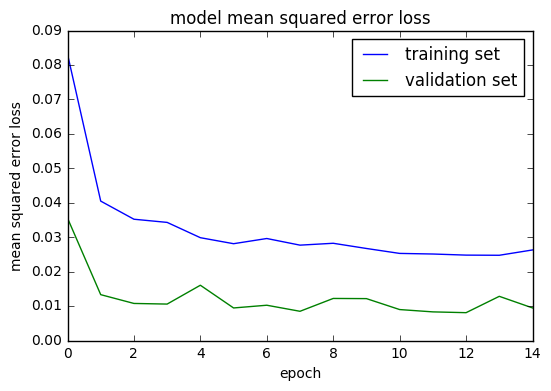

本地时间为 : Thu Mar 16 14:17:53 2017


SystemExit: 

C:\Anaconda3\envs\CarND\lib\site-packages\IPython\core\interactiveshell.py:2889: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [6]:
if __name__ == '__main__':
    tf.app.run()

In [ ]:
%tb